In [2]:
using Optim, Interpolations, Random, LinearAlgebra


# Backward Induction

In [25]:
mutable struct MyModel
    par::Dict{Symbol, Any}
    sol::Dict{Symbol, Any}

    function MyModel()
        model = new(Dict(), Dict())
        settings(model)
        setup(model)
        allocate(model)
        return model
    end
end

function settings(model)
end

function setup(model)
    par = model.par
    par[:N] = 4
    par[:a] = 2.0
    par[:b] = 1.0
    par[:threads] = 4
    #par.txt = 'a'
    #par.txtlist = 'N|threads'
end

function allocate(model)
    sol = model.sol
    par = model.par

    par[:x] = range(0, stop=1, length=par[:N])
    sol[:y] = zeros(par[:N])
end


function solve(model)
    par = model.par
    sol = model.sol

    sol[:y] .= par[:x] .* (par[:a] + par[:b])

end

model = MyModel()
solve(model)

# Print results
println(model.sol[:y])



[0.0, 1.0, 2.0, 3.0]


In [26]:
model = MyModel()
solve(model)

4-element Vector{Float64}:
 0.0
 1.0
 2.0
 3.0

My Coding for first for backward induction

In [8]:
mutable struct MyModel2
    par::Dict{Symbol, Any}
    sol::Dict{Symbol, Any}
    sim::Dict{Symbol, Any}

    function MyModel2()
        model = MyModel2(Dict(), Dict(), Dict())
        settings(model)
        setup(model)
        allocate(model)
        return model
    end
end

function setting(model)

end

function setup(model)
    model.par = Dict(
        :T = 20,
        :beta = 0.98,
        :rho = 2.0,

        :y = 1,
        :r = 0.02,
        :a_max = 30.0,
        :Na = 200,
        :simT = 20,
        :simN = 1000    )

end

function allocate(model)
    par = model.par
    sol = model.sol
    sim = model.sim

    par[:a_grid] = LinRange(0.0, par[:a_max], par[:Na])

    par[:yt] = fill(par[:y], par[:T])

    shape = (par[:T], par[:Na])
    sol[:c] = fill(NaN, par[:T], par[:Na])  # Equivalent to `np.nan + np.zeros(shape)`
    sol[:V] = fill(NaN, par[:T], par[:Na])

    shape = (par[:simN], par[:simT])
    sim[:c] = fill(NaN, par[:simN], par[:simT])
    sim[:a] = fill(NaN, par[:simN], par[:simT])
    sim[:a_init] = zeros(par[:simN])

end

function util(c, rho)
    return c^(1 - rho) / (1 - rho)
end


function solve(model)
    par = model.par
    sol = model.sol
    
    # b. Solve last period
    t = par[:T] - 1
    sol[:c][t, :] = par[:a_grid] .+ par[:yt][t]
    sol[:V][t, :] = util.(sol[:c][t, :], par[:rho])

    for t in reverse(0:(par[:T]-2))
        for ia in eachindex(par[:a_grid])
            assets = par[:a_grid][ia]
            obj = c -> -value_function(model, c[1], assets, t)
            lb = 1e-6
            ub = assets + par[:yt][t]


            if lb >= ub
                sol[:c][t, ia] = lb
                sol[:V][t, ia] = - obj(sol[:c][t, ia])

            else
                c_init = [lb + 0.5*ub]
                res = optimize(obj, lb, ub, c_init, Fminbox(LBFGS()))


                sol[:c][t, ia] = res.minimizer[1]
                sol[:v][t, ia] = res.minimum
            end
        end
    end
end

function value_function(model,cons,assets,t):

    # a. unpack
    par = self.par
    sol = self.sol

    # b. utility from consumption
    util = self.util(cons)

    # c. continuation value from savings
    V_next = sol[:V][t+1, :]
    a_next = (1.0+par.r)*(assets + par[:yt][t] - cons)
    V_next_interp = linear_interpolation(par.a_grid,V_next,extrapolation_bc=Line())
    V_next_interp = itp(a_next)

    # d. return value of choice
    return util + par.beta*V_next_interp
end







LoadError: syntax: invalid keyword argument name ":T" around In[8]:20

In [ ]:


mutable struct ConSavModel
    T::Int
    beta::Float64
    rho::Float64
    y::Float64
    r::Float64
    a_max::Float64
    Na::Int
    simT::Int
    simN::Int

    a_grid::Vector{Float64}
    yt::Vector{Float64}

    sol_c::Matrix{Float64}
    sol_V::Matrix{Float64}
    sim_c::Matrix{Float64}
    sim_a::Matrix{Float64}
    sim_a_init::Vector{Float64}

    function ConSavModel(T=20, beta=0.98, rho=2.0, y=1.0, r=0.02, a_max=30.0, Na=200, simN=1000)
        # Asset grid: Nonlinear spacing
        a_grid = nonlinspace(0.0, a_max, Na, 1.1)
        
        # Income over time
        yt = fill(y, T)

        # Allocate memory for solution and simulation matrices
        sol_c = Matrix{Float64}(undef, T, Na)
        sol_V = Matrix{Float64}(undef, T, Na)
        sim_c = Matrix{Float64}(undef, simN, T)
        sim_a = Matrix{Float64}(undef, simN, T)
        sim_a_init = zeros(simN)

        return new(T, beta, rho, y, r, a_max, Na, T, simN, a_grid, yt, sol_c, sol_V, sim_c, sim_a, sim_a_init)
    end
end

# Function for nonlinear spacing (same as Python's `nonlinspace()`)
function nonlinspace(start, stop, num, curvature)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curvature
    return start .+ (stop - start) .* curved_vals
end

# CRRA Utility Function
@inline function util(c, rho)
    return (c^(1 - rho)) / (1 - rho)
end

# **Solve the Model**
function solve_model!(model::ConSavModel)
    # Solve the last period
    t = model.T
    model.sol_c[t, :] .= model.a_grid .+ model.yt[t]
    model.sol_V[t, :] .= util.(model.sol_c[t, :], model.rho)

    # **Backward Induction**
    for t in (model.T-1):-1:1
        for ia in 1:model.Na  # Multi-threaded for performance
            assets = model.a_grid[ia]

            # Objective function for consumption choice
            obj = c -> -value_of_choice(model, c[1], assets, t)

            # Bounds on consumption
            lb = 1e-6  # Small value to avoid log(0)
            ub = assets + model.yt[t]

            # If no feasible bounds, set consumption to all resources
            if lb >= ub
                model.sol_c[t, ia] = ub
                model.sol_V[t, ia] = -obj([ub])
            else
                c_init = lb + 0.5 * ub  # Initial guess for optimization
                result = optimize(obj, [lb], [ub], [c_init], Fminbox(LBFGS()))
                
                # Store results
                model.sol_c[t, ia] = result.minimizer[1]
                model.sol_V[t, ia] = -result.minimum
            end
        end
    end
end

# **Value of Choice Function (Future Value + Utility)**
function value_of_choice(model::ConSavModel, cons, assets, t)
    util_val = util(cons, model.rho)  # Utility from consumption

    if t == model.T  # No future value in the last period
        return 
    end

    # Interpolating Value Function for t+1
    V_next = model.sol_V[t+1, :]
    a_next = (1.0 + model.r) * (assets + model.yt[t] - cons)

    itp = LinearInterpolation(model.a_grid, V_next, extrapolation_bc=Line())
    V_next_interp = itp(a_next)

    return util_val + model.beta * V_next_interp
end

# **Simulate Consumption-Savings Model**
function simulate!(model::ConSavModel)
    for i in 1:model.simN
        # **Initialize assets**
        model.sim_a[i, 1] = model.sim_a_init[i]

        for t in 1:model.simT
            if t <= model.T  # Ensure we do not exceed solution period

                # **Interpolate optimal consumption**
                itp = LinearInterpolation(model.a_grid, model.sol_c[t, :], extrapolation_bc=Line())
                model.sim_c[i, t] = itp(model.sim_a[i, t])

                # **Update next period's assets**
                if t < model.simT
                    model.sim_a[i, t+1] = (1 + model.r) * (model.sim_a[i, t] + model.yt[t] - model.sim_c[i, t])
                end
            end
        end
    end
end

# **Run Model**
model = ConSavModel()
solve_model!(model)
simulate!(model)

# **Print Some Results**
println("Asset Grid (first 5): ", model.a_grid[1:5])
println("Consumption at T-1 (first 5): ", model.sol_c[end, 1:5])


Asset Grid (first 5): [0.0, 0.08879384667949566, 0.19033377701519963, 0.2973146099717957, 0.4079893824583825]
Consumption at T-1 (first 5): [1.0, 1.0887938466794957, 1.1903337770151996, 1.2973146099717958, 1.4079893824583825]


Most Optimized style for Julia - ChatGPT used 

In [18]:

# --------------------------
# Helper Functions
# --------------------------
# Create a nonlinear spaced grid (similar to Python's nonlinspace)
function nonlinspace(start::Float64, stop::Float64, num::Int, curvature::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curvature
    return start .+ (stop - start) .* curved_vals
end

# CRRA Utility Function
@inline function util(c::Float64, rho::Float64)
    return (c^(1 - rho)) / (1 - rho)
end

# --------------------------
# Model Definition
# --------------------------
mutable struct ConSavModel
    # Model parameters
    T::Int               # Number of periods
    beta::Float64        # Discount factor
    rho::Float64         # Risk aversion coefficient
    y::Float64           # Income level (assumed constant over time)
    r::Float64           # Interest rate
    a_max::Float64       # Maximum asset level in grid
    Na::Int              # Number of grid points
    simT::Int            # Simulation time horizon
    simN::Int            # Number of simulated agents

    # Grids and time series
    a_grid::Vector{Float64}  # Asset grid
    yt::Vector{Float64}      # Income over time

    # Matrices for solution and simulation
    sol_c::Matrix{Float64}   # Optimal consumption (time × assets)
    sol_V::Matrix{Float64}   # Value function (time × assets)
    sim_c::Matrix{Float64}   # Simulated consumption paths (agents × time)
    sim_a::Matrix{Float64}   # Simulated asset paths (agents × time)
    sim_a_init::Vector{Float64}  # Initial assets for simulation

    # Constructor with default parameters
    function ConSavModel(T::Int=20, beta::Float64=0.98, rho::Float64=2.0, y::Float64=1.0, 
                         r::Float64=0.02, a_max::Float64=30.0, Na::Int=200, simN::Int=1000)
        a_grid = nonlinspace(0.0, a_max, Na, 1.1)
        yt = fill(y, T)

        sol_c = Matrix{Float64}(undef, T, Na)
        sol_V = Matrix{Float64}(undef, T, Na)
        sim_c = Matrix{Float64}(undef, simN, T)
        sim_a = Matrix{Float64}(undef, simN, T)
        sim_a_init = zeros(simN)

        # Here simT is set equal to T
        return new(T, beta, rho, y, r, a_max, Na, T, simN, a_grid, yt, sol_c, sol_V, sim_c, sim_a, sim_a_init)
    end
end

# --------------------------
# Model Solver
# --------------------------
# Calculate the value of a given consumption choice
function value_of_choice(model::ConSavModel, cons::Float64, assets::Float64, t::Int)
    u = util(cons, model.rho)
    # Terminal period: no future utility
    if t == model.T
        return u
    else
        # Next period's assets given current consumption
        a_next = (1 + model.r) * (assets + model.yt[t] - cons)
        # Interpolate the next period's value function
        itp = LinearInterpolation(model.a_grid, model.sol_V[t+1, :], extrapolation_bc=Line())
        V_next = itp(a_next)
        return u + model.beta * V_next
    end
end

# Solve the model via backward induction
function solve_model!(model::ConSavModel)
    T, Na = model.T, model.Na

    # Last period: consume all resources
    t = T
    model.sol_c[t, :] .= model.a_grid .+ model.yt[t]
    model.sol_V[t, :] .= util.(model.sol_c[t, :], model.rho)

    # Backward induction from period T-1 to 1
    for t in (T-1):-1:1
        for ia in 1:Na
            assets = model.a_grid[ia]
            # Define the objective function to be maximized
            obj = c -> -value_of_choice(model, c[1], assets, t)
            lb = 1e-6                      # Lower bound for consumption (avoid zero)
            ub = assets + model.yt[t]        # Upper bound: available resources
            c_init = [lb + 0.5*(ub - lb)]      # Initial guess for optimization

            # In degenerate cases, assign the resource level directly
            if lb >= ub
                model.sol_c[t, ia] = ub
                model.sol_V[t, ia] = -obj([ub])
            else
                result = optimize(obj, [lb], [ub], c_init, Fminbox(LBFGS()))
                model.sol_c[t, ia] = result.minimizer[1]
                model.sol_V[t, ia] = -result.minimum
            end
        end
    end
end

# --------------------------
# Simulation
# --------------------------
# Simulate consumption and asset paths based on the solved policy functions
function simulate!(model::ConSavModel)
    for i in 1:model.simN
        # Initialize starting asset level
        model.sim_a[i, 1] = model.sim_a_init[i]
        for t in 1:model.simT
            if t <= model.T
                # Interpolate the optimal consumption decision for current assets
                itp = LinearInterpolation(model.a_grid, model.sol_c[t, :], extrapolation_bc=Line())
                model.sim_c[i, t] = itp(model.sim_a[i, t])
                # Update assets for next period (if within simulation horizon)
                if t < model.simT
                    model.sim_a[i, t+1] = (1 + model.r) * (model.sim_a[i, t] + model.yt[t] - model.sim_c[i, t])
                end
            end
        end
    end
end

# --------------------------
# Main Routine
# --------------------------
function main()
    # Initialize model
    model = ConSavModel()

    # Solve for the policy functions via backward induction
    solve_model!(model)

    # Simulate the model
    simulate!(model)

    # Print sample results
    println("Asset Grid (first 5): ", model.a_grid[1:5])
    println("Consumption at last period (first 5): ", model.sol_c[end, 1:5])
end

# Execute the model
main()

Asset Grid (first 5): [0.0, 0.08879384667949566, 0.19033377701519963, 0.2973146099717957, 0.4079893824583825]
Consumption at last period (first 5): [1.0, 1.0887938466794957, 1.1903337770151996, 1.2973146099717958, 1.4079893824583825]


# Cake Eating Problem 

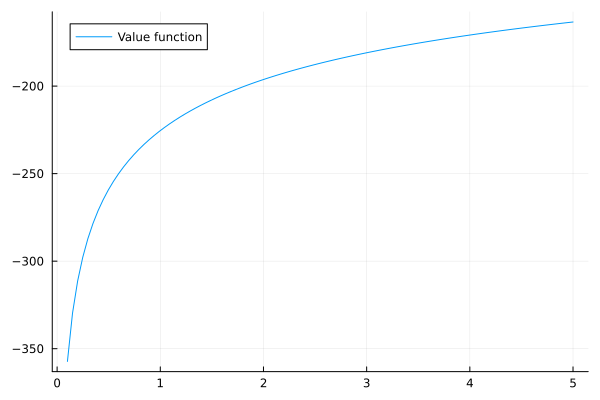

In [44]:
using Plots

# Define utility function with special case for γ = 1
function util(c, Y)
    return c^(1 - Y) / (1 - Y)
end

# Define value function
function v_star(x, β, γ)
    return (1 - β^(1/γ))^(-γ) * util(x, γ)
end

# Set parameters
β, γ = 0.95, 1.2

# Define x_grid correctly
x_grid = range(0.1, 5, 100)

# Plot the function
plot(x_grid, v_star.(x_grid, β, γ), label="Value function")

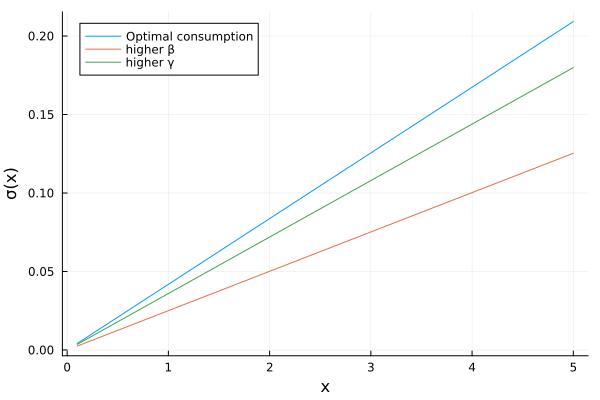

In [45]:
function c_star(x, β, γ)
    return (1 - β^(1/γ)) * x
end

plot(x_grid, c_star.(x_grid, β, γ), label="Optimal consumption")
plot!(x_grid, c_star.(x_grid, β + 0.02, γ), label="higher β")
plot!(x_grid, c_star.(x_grid, β , γ + 0.2), label="higher γ")
plot!(xlabel="x", ylabel="σ(x)", legend=:topleft)

In [2]:
using Plots, Optim

In [50]:
function util(c, Y)
    return c^(1 - Y) / (1 - Y)
end

function c_star(x, β, γ)
    return (1 - β^(1/γ)) * x
end

function v_star(x, β, γ)
    return (1 - β^(1/γ))^(-γ) * util(x, γ)
end

v_star (generic function with 1 method)

TypeError: TypeError: in typeassert, expected REPL.REPLCompletions.MethodCompletion, got a value of type REPL.REPLCompletions.TextCompletion

TypeError: TypeError: in typeassert, expected REPL.REPLCompletions.MethodCompletion, got a value of type REPL.REPLCompletions.TextCompletion

TypeError: TypeError: in typeassert, expected REPL.REPLCompletions.MethodCompletion, got a value of type REPL.REPLCompletions.TextCompletion

TypeError: TypeError: in typeassert, expected REPL.REPLCompletions.MethodCompletion, got a value of type REPL.REPLCompletions.TextCompletion

Basic Cake eating - from quantequn

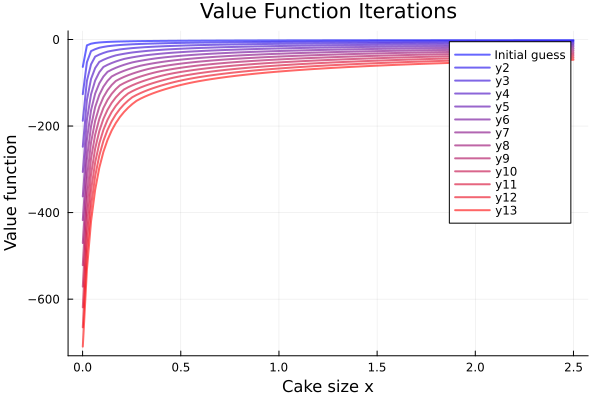

In [77]:

using Optim, Interpolations

# Utility function
function util(c::Float64, γ::Float64)
    return γ == 1 ? log(c) : (c^(1 - γ)) / (1 - γ)
end

# Bellman equation evaluation
function state_action_value(c::Float64, y::Float64, V::Vector{Float64}, a_grid::Vector{Float64}, γ::Float64, β::Float64)
    itp = LinearInterpolation(a_grid, V, extrapolation_bc=Line())  # Allow extrapolation
    return util(c, γ) + β * itp(y - c)
end

# Optimization function for maximizing the Bellman equation
function maxiiii(g, a, b)
    obj = x -> -g(x)  # Convert maximization to minimization
    result = optimize(obj, a, b, Brent())  # Brent method for 1D optimization
    maximizer = Optim.minimizer(result)
    maximum = -Optim.minimum(result)
    return maximizer, maximum
end

# --------------------------
# Model Definition
# --------------------------
mutable struct CakeEatingModel
    β::Float64           # Discount factor
    γ::Float64           # Risk aversion coefficient
    y::Float64           # Income level (constant)
    a_grid::Vector{Float64}  # Asset grid
    Na::Int              # Number of grid points
    V::Vector{Float64}   # Value function storage
    c::Vector{Float64}   # Policy function storage

    function CakeEatingModel(β::Float64=0.96, γ::Float64=1.5, y::Float64=1.0, 
                             a_max::Float64=2.5, Na::Int=120)
        a_grid = range(1e-3, stop=a_max, length=Na) |> collect

        # Initialize value function and policy function
        V = zeros(Na)  # Start with zero value function
        c = zeros(Na)  # Start with zero policy function

        return new(β, γ, y, a_grid, Na, V, c)
    end
end

# Bellman operator (updates value function)
function T(V::Vector{Float64}, model::CakeEatingModel)
    """
    The Bellman operator. Updates the guess of the value function.

    - `model` is an instance of `CakeEatingModel`
    - `V` is an array representing a guess of the value function

    Returns:
    - `v_new`: Updated value function
    """
    v_new = similar(V)  # Initialize a new value function array

    for (i, x) in enumerate(model.a_grid)
        let x_fixed = x
            _, v_new[i] = maxiiii(c -> state_action_value(c, x_fixed, V, model.a_grid, model.γ, model.β), 
                                  1e-10, x_fixed)
        end
    end

    return v_new
end


model = CakeEatingModel()

# Set up value function iteration
x_grid = model.a_grid  # Asset/cake grid
V = util.(x_grid, model.γ)  # Initial guess for the value function
n = 12  # Number of iterations


p = plot(x_grid, V, lw=2, alpha=0.6, label="Initial guess", color=:blue)

for i in 1:n
    V = T(V, model)  # Apply the Bellman operator
    plot!(p, x_grid, V, lw=2, alpha=0.6, color=RGB(i / n, 0, 1 - i / n))
end

plot!(p, xlabel="Cake size x", ylabel="Value function", 
         title="Value Function Iterations", legend=:topright)

display(p)

# Buffer Stock Model

In [3]:
# --------------------------
# Helper Functions
# --------------------------
using Random, Optim, Interpolations

# Create a nonlinear spaced grid (similar to Python's nonlinspace)
function nonlinspace(start::Float64, stop::Float64, num::Int, curvature::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curvature
    return start .+ (stop - start) .* curved_vals
end

# Simple linear interpolation wrapper (using Interpolations.jl)
function interp_1d(x::Vector{Float64}, y::Vector{Float64}, x_new::Float64)
    itp = LinearInterpolation(x, y, extrapolation_bc=Line())
    return itp(x_new)
end

# Dummy placeholder for log_normal_gauss_hermite
# In practice, replace this with your actual implementation
function log_normal_gauss_hermite(sigma::Float64, N::Int)
    # For illustration, we use symmetric nodes and equal weights.
    # A proper implementation would return Gauss-Hermite nodes and weights
    nodes = range(exp(-sigma), stop=exp(sigma), length=N) |> collect
    weights = fill(1.0/N, N)
    return nodes, weights
end

# --------------------------
# Model Definition
# --------------------------
mutable struct BufferStockModel
    # Fundamental parameters
    T::Int                # Number of periods
    beta::Float64         # Discount factor
    rho::Float64          # CRRA coefficient
    G::Float64            # Income growth factor
    sigma_trans::Float64  # Transitory income shock std dev
    sigma_perm::Float64   # Permanent income shock std dev
    r::Float64            # Interest rate

    # Grid and simulation parameters
    m_max::Float64        # Maximum resource level
    Nm::Int               # Number of grid points for resources
    Nxi::Int              # Number of points in transitory shock grid
    Npsi::Int             # Number of points in permanent shock grid
    seed::Int             # Random seed
    simT::Int             # Simulation time horizon
    simN::Int             # Number of simulated individuals

    # Grids and shock arrays
    m_grid::Vector{Float64}      # Resource grid
    xi_grid::Vector{Float64}     # Transitory shock grid
    xi_weight::Vector{Float64}   # Weights for transitory shocks
    psi_grid::Vector{Float64}    # Permanent shock grid
    psi_weight::Vector{Float64}  # Weights for permanent shocks

    # Solution arrays (dimensions: T x Nm)
    sol_c::Matrix{Float64}       # Optimal consumption policy
    sol_V::Matrix{Float64}       # Value function

    # Simulation arrays (dimensions: simN x simT)
    sim_c::Matrix{Float64}       # Simulated consumption (normalized)
    sim_m::Matrix{Float64}       # Simulated normalized resources
    sim_a::Matrix{Float64}       # Simulated assets (normalized)
    sim_C::Matrix{Float64}       # (Optional) consumption in levels
    sim_M::Matrix{Float64}       # Total resources in levels
    sim_A::Matrix{Float64}       # Assets in levels
    sim_P::Matrix{Float64}       # Permanent income
    sim_Y::Matrix{Float64}       # Income

    # Initial conditions and shock draws
    sim_a_init::Vector{Float64}  # Initial assets (normalized)
    sim_P_init::Vector{Float64}  # Initial permanent income
    sim_xi::Matrix{Float64}      # Drawn transitory shocks (simN x simT)
    sim_psi::Matrix{Float64}     # Drawn permanent shocks (simN x simT)
end

# Constructor with default parameters; arrays are allocated later.
function BufferStockModel(; T=20, beta=0.98, rho=2.0, G=1.03,
                            sigma_trans=0.1, sigma_perm=0.1, r=0.02,
                            m_max=20.0, Nm=50, Nxi=5, Npsi=5,
                            seed=9210, simT=20, simN=1000)
    m_grid       = Float64[]
    xi_grid      = Float64[]
    xi_weight    = Float64[]
    psi_grid     = Float64[]
    psi_weight   = Float64[]

    sol_c        = Array{Float64}(undef, T, Nm)
    sol_V        = Array{Float64}(undef, T, Nm)

    sim_c        = Array{Float64}(undef, simN, simT)
    sim_m        = Array{Float64}(undef, simN, simT)
    sim_a        = Array{Float64}(undef, simN, simT)
    sim_C        = Array{Float64}(undef, simN, simT)
    sim_M        = Array{Float64}(undef, simN, simT)
    sim_A        = Array{Float64}(undef, simN, simT)
    sim_P        = Array{Float64}(undef, simN, simT)
    sim_Y        = Array{Float64}(undef, simN, simT)

    sim_a_init   = zeros(simN)
    sim_P_init   = ones(simN)

    sim_xi       = Array{Float64}(undef, simN, simT)
    sim_psi      = Array{Float64}(undef, simN, simT)

    return BufferStockModel(T, beta, rho, G, sigma_trans, sigma_perm, r,
                            m_max, Nm, Nxi, Npsi, seed, simT, simN,
                            m_grid, xi_grid, xi_weight, psi_grid, psi_weight,
                            sol_c, sol_V,
                            sim_c, sim_m, sim_a, sim_C, sim_M, sim_A, sim_P, sim_Y,
                            sim_a_init, sim_P_init, sim_xi, sim_psi)
end

# --------------------------
# Model Allocation & Setup
# --------------------------
function allocate_model!(model::BufferStockModel)
    # a. Asset grid
    model.m_grid = nonlinspace(0.00001, model.m_max, model.Nm, 1.1)
    
    # b. Income shock grids (using a Gauss-Hermite quadrature routine)
    model.xi_grid, model.xi_weight = log_normal_gauss_hermite(model.sigma_trans, model.Nxi)
    model.psi_grid, model.psi_weight = log_normal_gauss_hermite(model.sigma_perm, model.Npsi)
    
    # c. Initialize solution arrays with NaN
    model.sol_c .= NaN
    model.sol_V .= NaN
    
    # d. Initialize simulation arrays with NaN
    model.sim_c .= NaN
    model.sim_m .= NaN
    model.sim_a .= NaN
    model.sim_C .= NaN
    model.sim_M .= NaN
    model.sim_A .= NaN
    model.sim_P .= NaN
    model.sim_Y .= NaN

    # e. Set initial conditions for simulation
    model.sim_a_init .= 0.0
    model.sim_P_init .= 1.0

    # f. Generate random log-normal shocks (normalized to mean one)
    Random.seed!(model.seed)
    model.sim_xi .= exp.(model.sigma_trans .* randn(model.simN, model.simT) .- 0.5 * model.sigma_trans^2)
    model.sim_psi .= exp.(model.sigma_perm  .* randn(model.simN, model.simT) .- 0.5 * model.sigma_perm^2)
end

# --------------------------
# Model Utility and Value Functions
# --------------------------
@inline function util(model::BufferStockModel, c::Float64)
    return c^(1.0 - model.rho) / (1.0 - model.rho)
end

function value_of_choice(model::BufferStockModel, cons::Float64, resources::Float64, t::Int)
    # a. Immediate utility from consumption
    u = util(model, cons)
    
    # b. Expected continuation value (if not terminal period)
    V_next = model.sol_V[t+1, :]  # next period value function over grid
    assets = resources - cons
    EV_next = 0.0

    # Loop over income shocks
    for i in eachindex(model.xi_grid)
        for j in eachindex(model.psi_grid)
            fac = model.G * model.psi_grid[j]  # normalization factor
            m_next = (1.0 + model.r) * assets / fac + model.xi_grid[i]
            V_next_interp = interp_1d(model.m_grid, V_next, m_next)
            V_next_interp *= fac^(1.0 - model.rho)
            EV_next += V_next_interp * model.xi_weight[i] * model.psi_weight[j]
        end
    end

    return u + model.beta * EV_next
end

# --------------------------
# Model Solver (Backward Induction)
# --------------------------
function solve_model!(model::BufferStockModel)
    T, Nm = model.T, model.Nm

    # Terminal period: consume all available resources
    t = T
    model.sol_c[t, :] .= model.m_grid
    model.sol_V[t, :] .= util.(Ref(model), model.sol_c[t, :])
    
    # Backward induction from period T-1 down to 1
    for t in (T-1):-1:1
        for im in 1:Nm
            resources = model.m_grid[im]
            
            # Objective: negative value since we use a minimizer
            obj(c) = -value_of_choice(model, c[1], resources, t)
            
            lb = 1e-6  # lower bound on consumption
            ub = resources  # cannot consume more than available resources
            
            if lb >= ub
                model.sol_c[t, im] = ub
                model.sol_V[t, im] = -obj([ub])
            else
                # Initial guess is half the available resources
                c_init = [0.5 * ub]
                res = optimize(obj, [lb], [ub], c_init, Fminbox(LBFGS()))
                model.sol_c[t, im] = Optim.minimizer(res)[1]
                model.sol_V[t, im] = -Optim.minimum(res)
            end
        end
    end
end

# --------------------------
# Model Simulation
# --------------------------
function simulate_model!(model::BufferStockModel)
    for i in 1:model.simN
        # Initialization at t = 1
        t = 1
        model.sim_P[i, t] = model.sim_P_init[i]
        model.sim_Y[i, t] = model.sim_P[i, t] * model.sim_xi[i, t]
        model.sim_a[i, t] = model.sim_a_init[i]
        model.sim_A[i, t] = model.sim_a[i, t] * model.sim_P[i, t]
        model.sim_M[i, t] = (1.0 + model.r) * model.sim_A[i, t] + model.sim_Y[i, t]
        model.sim_m[i, t] = model.sim_M[i, t] / model.sim_P[i, t]
        
        # Loop over time periods
        for t in 1:(model.simT - 1)
            if t <= model.T
                # Interpolate optimal consumption (normalized)
                model.sim_c[i, t] = interp_1d(model.m_grid, model.sol_c[t, :], model.sim_m[i, t])
            end
            # Update next period's states
            model.sim_P[i, t+1] = model.G * model.sim_P[i, t] * model.sim_psi[i, t+1]
            model.sim_Y[i, t+1] = model.sim_P[i, t+1] * model.sim_xi[i, t+1]
            model.sim_a[i, t+1] = model.sim_m[i, t] - model.sim_c[i, t]
            model.sim_A[i, t+1] = model.sim_a[i, t+1] * model.sim_P[i, t+1]
            model.sim_M[i, t+1] = (1.0 + model.r) * model.sim_A[i, t+1] + model.sim_Y[i, t+1]
            model.sim_m[i, t+1] = model.sim_M[i, t+1] / model.sim_P[i, t+1]
        end
    end
end

# --------------------------
# Main Routine
# --------------------------
function main()
    # Initialize model with default parameters
    model = BufferStockModel()

    # Allocate grids, arrays, and shocks
    allocate_model!(model)

    # Solve for optimal consumption policy via backward induction
    solve_model!(model)

    # Simulate the model
    simulate_model!(model)

    # Print sample results
    println("Resource Grid (first 5): ", model.m_grid[1:5])
    println("Optimal consumption in terminal period (first 5): ", model.sol_c[model.T, 1:5])
end

main()

LoadError: InterruptException:

In [3]:
using FastGaussQuadrature
using Interpolations
using Optim
using Random

### Parameter Struct
mutable struct Par
    T::Int                  # Time periods
    beta::Float64           # Discount factor
    rho::Float64            # CRRA coefficient
    G::Float64              # Income growth level
    sigma_trans::Float64    # Transitory income shock std
    sigma_perm::Float64     # Permanent income shock std
    r::Float64              # Interest rate
    m_max::Float64          # Maximum resources in grid
    Nm::Int                 # Number of grid points for resources
    Nxi::Int                # Number of transitory shock points
    Npsi::Int               # Number of permanent shock points
    seed::Int               # Random seed
    simT::Int               # Simulation periods
    simN::Int               # Number of individuals
    m_grid::Vector{Float64} # Resource grid
    xi_grid::Vector{Float64} # Transitory shock grid
    xi_weight::Vector{Float64} # Transitory shock weights
    psi_grid::Vector{Float64} # Permanent shock grid
    psi_weight::Vector{Float64} # Permanent shock weights
end

### Solution Struct
mutable struct Sol
    c::Array{Float64,2}  # Consumption policy (T, Nm)
    V::Array{Float64,2}  # Value function (T, Nm)
end

### Simulation Struct
mutable struct Sim
    c::Array{Float64,2}  # Normalized consumption (simN, simT)
    m::Array{Float64,2}  # Normalized resources
    a::Array{Float64,2}  # Normalized assets
    C::Array{Float64,2}  # Consumption level
    M::Array{Float64,2}  # Resource level
    A::Array{Float64,2}  # Asset level
    P::Array{Float64,2}  # Permanent income
    Y::Array{Float64,2}  # Total income
    a_init::Vector{Float64} # Initial normalized assets
    P_init::Vector{Float64} # Initial permanent income
    xi::Array{Float64,2}    # Transitory shocks
    psi::Array{Float64,2}   # Permanent shocks
end

### Model Struct
if !isdefined(Main, :BufferStockModel)
    mutable struct BufferStockModel
        par::Par
        sol::Sol
        sim::Sim
    end
end

### Initialization Functions

function nonlinspace(a, b, n, p)
    """Create a non-linear grid from a to b with n points and power p."""
    lin = range(0, 1, length=n)
    return a .+ (b - a) .* (lin .^ p)
end

function initialize_par()
    """Set up baseline parameters and grids."""
    par = Par(
        20,      # T
        0.98,    # beta
        2.0,     # rho
        1.03,    # G
        0.1,     # sigma_trans
        0.1,     # sigma_perm
        0.02,    # r
        20.0,    # m_max
        50,      # Nm
        5,       # Nxi
        5,       # Npsi
        9210,    # seed
        20,      # simT
        1000,    # simN
        Float64[], # m_grid
        Float64[], # xi_grid
        Float64[], # xi_weight
        Float64[], # psi_grid
        Float64[]  # psi_weight
    )
    
    # Resource grid
    par.m_grid = nonlinspace(0.00001, par.m_max, par.Nm, 1.1)
    
    # Income shock grids using Gauss-Hermite quadrature
    x, w = gausshermite(par.Nxi)
    par.xi_grid = exp.(par.sigma_trans * sqrt(2) * x .- 0.5 * par.sigma_trans^2)
    par.xi_weight = w ./ sqrt(pi)
    par.xi_weight ./= sum(par.xi_weight)  # Normalize
    
    x, w = gausshermite(par.Npsi)
    par.psi_grid = exp.(par.sigma_perm * sqrt(2) * x .- 0.5 * par.sigma_perm^2)
    par.psi_weight = w ./ sqrt(pi)
    par.psi_weight ./= sum(par.psi_weight)  # Normalize
    
    return par
end

function initialize_sol(par)
    """Allocate solution arrays."""
    shape = (par.T, par.Nm)
    return Sol(
        fill(NaN, shape),
        fill(NaN, shape)
    )
end

function initialize_sim(par)
    """Allocate simulation arrays and initialize shocks."""
    shape = (par.simN, par.simT)
    sim = Sim(
        fill(NaN, shape), # c
        fill(NaN, shape), # m
        fill(NaN, shape), # a
        fill(NaN, shape), # C
        fill(NaN, shape), # M
        fill(NaN, shape), # A
        fill(NaN, shape), # P
        fill(NaN, shape), # Y
        zeros(par.simN),  # a_init
        ones(par.simN),   # P_init
        fill(NaN, shape), # xi
        fill(NaN, shape)  # psi
    )
    
    # Generate log-normal shocks
    Random.seed!(par.seed)
    sim.xi = exp.(par.sigma_trans .* randn(shape) .- 0.5 * par.sigma_trans^2)
    sim.psi = exp.(par.sigma_perm .* randn(shape) .- 0.5 * par.sigma_perm^2)
    
    return sim
end

function initialize_model()
    """Initialize the entire model."""
    par = initialize_par()
    sol = initialize_sol(par)
    sim = initialize_sim(par)
    return BufferStockModel(par, sol, sim)
end

### Utility Function
function util(c, par)
    """Compute CRRA utility."""
    return c > 0 ? (c^(1.0 - par.rho)) / (1.0 - par.rho) : -1e10
end

### Value of Choice Function
function value_of_choice(cons, resources, t, par, sol, V_next_interp)
    """Compute the value of a consumption choice."""
    assets = resources - cons
    if assets < 0
        return -1e10
    end
    
    util_val = util(cons, par)
    EV_next = 0.0
    
    for i_xi in 1:par.Nxi
        for i_psi in 1:par.Npsi
            xi = par.xi_grid[i_xi]
            psi = par.psi_grid[i_psi]
            fac = par.G * psi
            m_next = (1.0 + par.r) * assets / fac + xi
            V_next_val = V_next_interp(m_next)
            V_next_val *= fac^(1.0 - par.rho)
            EV_next += V_next_val * par.xi_weight[i_xi] * par.psi_weight[i_psi]
        end
    end
    
    return util_val + par.beta * EV_next
end

### Solve Function
function solve!(model)
    """Solve the model backwards."""
    par = model.par
    sol = model.sol
    
    # Last period: consume all resources
    sol.c[par.T, :] = par.m_grid
    sol.V[par.T, :] = util.(par.m_grid, Ref(par))
    
    # Loop backwards
    for t in reverse(1:par.T-1)
        V_next_interp = LinearInterpolation(par.m_grid, sol.V[t+1, :], extrapolation_bc=Line())
        for im in 1:par.Nm
            resources = par.m_grid[im]
            lb = 0.000001  # Lower bound
            ub = resources  # Upper bound
            obj(c) = -value_of_choice(c, resources, t, par, sol, V_next_interp)
            res = optimize(obj, lb, ub, Brent())
            sol.c[t, im] = res.minimizer
            sol.V[t, im] = -res.minimum
        end
    end
end

### Simulate Function
function simulate!(model)
    """Simulate the model forward."""
    par = model.par
    sol = model.sol
    sim = model.sim
    
    for i in 1:par.simN
        # Initialize at t=1
        sim.P[i, 1] = sim.P_init[i]
        sim.Y[i, 1] = sim.P[i, 1] * sim.xi[i, 1]
        sim.a[i, 1] = sim.a_init[i]
        sim.A[i, 1] = sim.a[i, 1] * sim.P[i, 1]
        sim.M[i, 1] = (1.0 + par.r) * sim.A[i, 1] + sim.Y[i, 1]
        sim.m[i, 1] = sim.M[i, 1] / sim.P[i, 1]
        
        for t in 1:par.simT
            if t <= par.T
                # Interpolate consumption
                c_interp = LinearInterpolation(par.m_grid, sol.c[t, :], extrapolation_bc=Line())
                sim.c[i, t] = c_interp(sim.m[i, t])
                
                # Update next period states
                if t < par.simT
                    sim.P[i, t+1] = par.G * sim.P[i, t] * sim.psi[i, t+1]
                    sim.Y[i, t+1] = sim.P[i, t+1] * sim.xi[i, t+1]
                    sim.a[i, t+1] = sim.m[i, t] - sim.c[i, t]
                    sim.A[i, t+1] = sim.a[i, t+1] * sim.P[i, t+1]
                    sim.M[i, t+1] = (1.0 + par.r) * sim.A[i, t+1] + sim.Y[i, t+1]
                    sim.m[i, t+1] = sim.M[i, t+1] / sim.P[i, t+1]
                end
            end
        end
    end
end

### Usage Example
model = initialize_model()
solve!(model)
simulate!(model)

# Access results, e.g., consumption
# println(model.sim.c)